In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm  # Barra di avanzamento carina per Jupyter

# Dataset specifici
from mnist1d.data import get_dataset, get_dataset_args
from mnist1d.utils import set_seed
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

# Configurazione Device (Fondamentale per usare la tua GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Setup completato.")
print(f"Device in uso: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Setup completato.
Device in uso: cuda
GPU: NVIDIA GeForce GTX 1660


In [2]:
def centering_matrix(n, device):
    """Matrice di centraggio H = I - 1/n"""
    H = torch.eye(n, device=device) - torch.ones((n, n), device=device) / n
    return H

def linear_hsic(X, Y, device):
    """Calcola Hilbert-Schmidt Independence Criterion (Linear Kernel)"""
    n = X.shape[0]
    K = torch.matmul(X, X.T) # Gram Matrix X
    L = torch.matmul(Y, Y.T) # Gram Matrix Y
    H = centering_matrix(n, device)
    
    # Trace(KHLH) / (n-1)^2
    KH = torch.matmul(K, H)
    LH = torch.matmul(L, H)
    return torch.trace(torch.matmul(KH, LH)) / ((n - 1) ** 2)

def linear_cka(X, Y):
    """
    Calcola la Linear CKA tra due matrici di feature.
    X, Y devono avere lo stesso numero di righe (samples).
    """
    assert X.shape[0] == Y.shape[0], f"Errore dimensioni: {X.shape[0]} vs {Y.shape[0]}"
    
    hsic_xy = linear_hsic(X, Y, X.device)
    hsic_xx = linear_hsic(X, X, X.device)
    hsic_yy = linear_hsic(Y, Y, Y.device)
    
    return hsic_xy / (torch.sqrt(hsic_xx) * torch.sqrt(hsic_yy))

In [3]:
def get_balanced_features(model, data_loader, device, num_samples_per_class=50):
    """
    Estrae le feature dal modello e restituisce un tensore ordinato e bilanciato.
    Output: Tensore di shape (10 * num_samples_per_class, feature_dim)
            Ordinato: [50 zeri, 50 uni, ..., 50 nove]
    """
    model.eval()
    
    # 1. Raccogli tutte le feature e label
    all_feats = []
    all_labels = []
    
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            # Fix per MNIST-1D se arriva come numpy array
            if not isinstance(x, torch.Tensor): 
                x = torch.tensor(x).float().to(device)
            
            # Forward pass (assumiamo che il modello ritorni: logits, features)
            _, feats = model(x)
            all_feats.append(feats)
            all_labels.append(y)
            
    cat_feats = torch.cat(all_feats, dim=0)
    cat_labels = torch.cat(all_labels, dim=0).cpu() # CPU per indexing facile
    
    # 2. Seleziona N campioni per ogni classe
    balanced_feats = []
    for class_idx in range(10):
        # Trova indici dove label == class_idx
        indices = (cat_labels == class_idx).nonzero(as_tuple=True)[0]
        
        if len(indices) < num_samples_per_class:
            raise ValueError(f"Classe {class_idx} ha solo {len(indices)} campioni, ne servono {num_samples_per_class}")
            
        selected_indices = indices[:num_samples_per_class]
        balanced_feats.append(cat_feats[selected_indices])
        
    # 3. Concatena in un unico blocco ordinato
    return torch.cat(balanced_feats, dim=0)

In [4]:
# Cella 4 (Fix Finale): Modello e Training MNIST-1D
class Mnist1DNet(nn.Module):
    def __init__(self, input_size=40):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        h = self.features(x)
        out = self.classifier(h)
        return out, h

def train_mnist1d(seed, args):
    set_seed(seed)
    
    # 1. Carica dataset
    data = get_dataset(args, path='./mnist1d_data.pkl', download=True, regenerate=False)
    
    # 2. Prepara i tensori
    x_train = torch.Tensor(data['x']).float().to(device)
    y_train = torch.LongTensor(data['y']).to(device)
    x_test = torch.Tensor(data['x_test']).float().to(device)
    y_test = torch.LongTensor(data['y_test'])
    
    # --- FIX CRUCIALE QUI ---
    # Leggiamo la dimensione direttamente dai dati caricati
    # x_train.shape è (N_samples, Input_dim), quindi prendiamo l'indice 1
    real_input_dim = x_train.shape[1] 
    # ------------------------

    # 3. Setup Training
    test_ds = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_ds, batch_size=100, shuffle=False)

    model = Mnist1DNet(input_size=real_input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    # 4. Training Loop
    model.train()
    for _ in range(50):
        optimizer.zero_grad()
        logits, _ = model(x_train)
        loss = criterion(logits, y_train)
        loss.backward()
        optimizer.step()
        
    return model, test_loader

In [5]:
class Mnist2DNet(nn.Module):
    def __init__(self):
        super().__init__()
        # CNN Semplice
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2), 
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(32*7*7, 128), nn.ReLU() # Proiezione a 128 dim
        )
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        h = self.features(x)
        out = self.classifier(h)
        return out, h

def train_mnist2d(seed):
    # Impostiamo il seed per la riproducibilità/variabilità
    set_seed(seed)
    
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_ds = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_ds = datasets.MNIST('./data', train=False, transform=transform)
    
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)
    
    model = Mnist2DNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    epochs = 3
    for epoch in range(epochs):
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Seed {seed})")
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits, _ = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            pbar.set_postfix({'loss': loss.item()})
            
    return model, test_loader

🔹 Training 5 MNIST-1D models...
File already exists. Skipping download.
Successfully loaded data from ./mnist1d_data.pkl
   Model 1D #1 trained.
File already exists. Skipping download.
Successfully loaded data from ./mnist1d_data.pkl
   Model 1D #2 trained.
File already exists. Skipping download.
Successfully loaded data from ./mnist1d_data.pkl
   Model 1D #3 trained.
File already exists. Skipping download.
Successfully loaded data from ./mnist1d_data.pkl
   Model 1D #4 trained.
File already exists. Skipping download.
Successfully loaded data from ./mnist1d_data.pkl
   Model 1D #5 trained.

🔹 Training 5 MNIST-2D models...


Epoch 1/3 (Seed 100):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/3 (Seed 100):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/3 (Seed 100):   0%|          | 0/938 [00:00<?, ?it/s]

   Model 2D #1 trained.


Epoch 1/3 (Seed 101):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/3 (Seed 101):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/3 (Seed 101):   0%|          | 0/938 [00:00<?, ?it/s]

   Model 2D #2 trained.


Epoch 1/3 (Seed 102):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/3 (Seed 102):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/3 (Seed 102):   0%|          | 0/938 [00:00<?, ?it/s]

   Model 2D #3 trained.


Epoch 1/3 (Seed 103):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/3 (Seed 103):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/3 (Seed 103):   0%|          | 0/938 [00:00<?, ?it/s]

   Model 2D #4 trained.


Epoch 1/3 (Seed 104):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/3 (Seed 104):   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/3 (Seed 104):   0%|          | 0/938 [00:00<?, ?it/s]

   Model 2D #5 trained.

🔹 Computing CKA Matrices...

📊 RISULTATI FINALI
1. Convergenza 1D (Self-CKA): 0.9679
   (Quanto sono simili tra loro i modelli 1D)
2. Convergenza 2D (Self-CKA): 0.9367
   (Quanto sono simili tra loro i modelli 2D)
3. Platonic Score (1D vs 2D): 0.2445
   (Media della similarità tra geometria 1D e 2D)


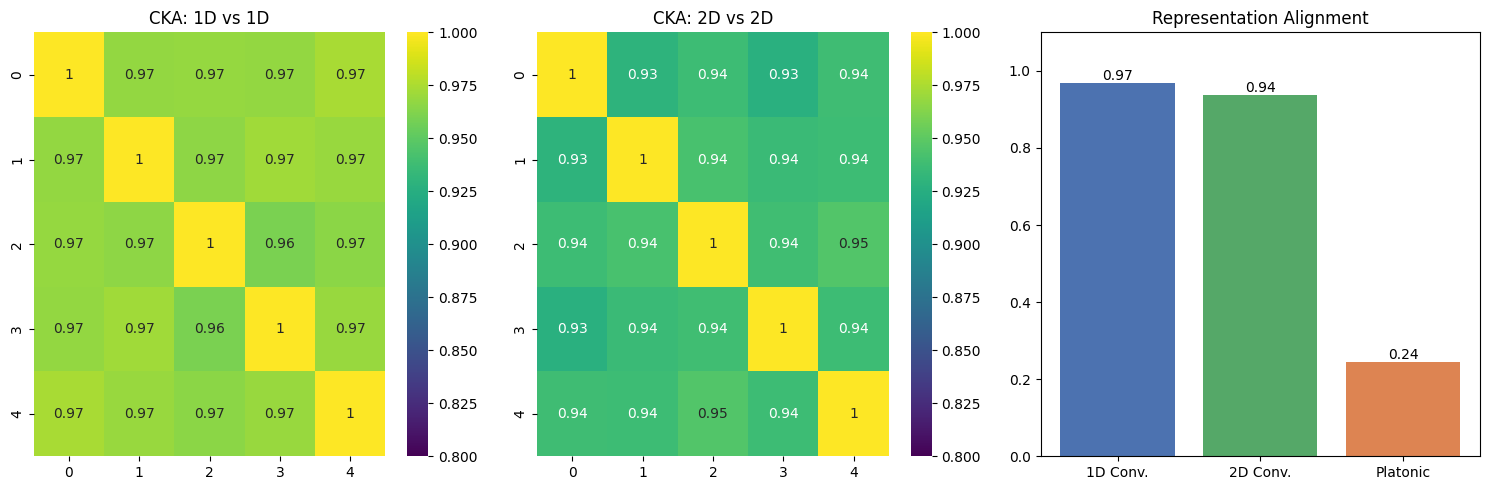

In [6]:
# --- CONFIGURAZIONE ESPERIMENTO ---
NUM_MODELS = 5
SAMPLES_PER_CLASS = 80 

# 1. Addestramento 5 Modelli 1D
print(f"🔹 Training {NUM_MODELS} MNIST-1D models...")
args_1d = get_dataset_args()
feats_1d_list = []
for i in range(NUM_MODELS):
    seed = 42 + i
    m, l = train_mnist1d(seed, args_1d)
    feats_1d_list.append(get_balanced_features(m, l, device, SAMPLES_PER_CLASS))
    print(f"   Model 1D #{i+1} trained.")

# 2. Addestramento 5 Modelli 2D
print(f"\n🔹 Training {NUM_MODELS} MNIST-2D models...")
feats_2d_list = []
for i in range(NUM_MODELS):
    seed = 100 + i # Seed diversi dai modelli 1D
    m, l = train_mnist2d(seed)
    feats_2d_list.append(get_balanced_features(m, l, device, SAMPLES_PER_CLASS))
    print(f"   Model 2D #{i+1} trained.")

# 3. Calcolo Similarità (CKA)
print("\n🔹 Computing CKA Matrices...")

def compute_cka_matrix(list_a, list_b):
    size_a, size_b = len(list_a), len(list_b)
    matrix = torch.zeros((size_a, size_b))
    for i in range(size_a):
        for j in range(size_b):
            matrix[i, j] = linear_cka(list_a[i], list_b[j])
    return matrix

cka_1d_1d = compute_cka_matrix(feats_1d_list, feats_1d_list)
cka_2d_2d = compute_cka_matrix(feats_2d_list, feats_2d_list)
cka_cross = compute_cka_matrix(feats_1d_list, feats_2d_list)

# Calcolo delle medie
# Per il self-CKA escludiamo la diagonale (che è sempre 1.0)
mask = torch.eye(NUM_MODELS) == 0
mean_self_cka_1d = cka_1d_1d[mask].mean().item()
mean_self_cka_2d = cka_2d_2d[mask].mean().item()
# Per il Platonic Score usiamo la media di tutti i confronti incrociati (25 coppie)
mean_platonic_score = cka_cross.mean().item()

# --- RISULTATI (Mantenuto come richiesto) ---
print("\n" + "="*30)
print(f"📊 RISULTATI FINALI")
print("="*30)
print(f"1. Convergenza 1D (Self-CKA): {mean_self_cka_1d:.4f}")
print(f"   (Quanto sono simili tra loro i modelli 1D)")
print(f"2. Convergenza 2D (Self-CKA): {mean_self_cka_2d:.4f}")
print(f"   (Quanto sono simili tra loro i modelli 2D)")
print(f"3. Platonic Score (1D vs 2D): {mean_platonic_score:.4f}")
print(f"   (Media della similarità tra geometria 1D e 2D)")

# Visualizzazione
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cka_1d_1d.cpu().numpy(), annot=True, cmap='viridis', vmin=0.8)
plt.title("CKA: 1D vs 1D")

plt.subplot(1, 3, 2)
sns.heatmap(cka_2d_2d.cpu().numpy(), annot=True, cmap='viridis', vmin=0.8)
plt.title("CKA: 2D vs 2D")

plt.subplot(1, 3, 3)
bars = plt.bar(["1D Conv.", "2D Conv.", "Platonic"], 
                [mean_self_cka_1d, mean_self_cka_2d, mean_platonic_score], 
                color=['#4c72b0', '#55a868', '#dd8452'])
plt.ylim(0, 1.1)
plt.title("Representation Alignment")
plt.bar_label(bars, fmt='%.2f')

plt.tight_layout()
plt.show()